# ✈️ STUDENT TRAVEL RECOMMENDER

# STEP 1: Import all required libraries

In [1]:
import os
import json
import math
import random
import requests
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set display options for better readability
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)

# STEP 2: Load dataset or create demo data

In [2]:
DATA_PATH = '../backend/data/Dataset.csv'

if not os.path.exists(DATA_PATH):
    print('Dataset not found. Creating demo dataset...')
    demo = pd.DataFrame({
        'city': ['Goa','Jaipur','Manali','Munnar','Pondicherry','Varanasi','Shimla','Darjeeling','Agra','Pune'],
        'state': ['Goa','Rajasthan','Himachal','Kerala','Puducherry','Uttar Pradesh','Himachal','West Bengal','Uttar Pradesh','Maharashtra'],
        'category': ['Beach','Heritage','Hill Station','Hill Station','Beach','Pilgrimage','Hill Station','Hill Station','Heritage','City'],
        'best_time': ['Nov-Mar','Oct-Mar','Mar-Jun','Sep-Mar','Nov-Feb','Oct-Mar','Mar-Jun','Mar-May','Oct-Mar','Oct-Mar'],
        'est_cost_level': [2,2,3,3,2,2,3,3,2,2],
        'popularity': [95,85,78,65,60,90,70,55,88,66]
    })
    os.makedirs('data', exist_ok=True)
    demo.to_csv('data/demo_student_trips.csv', index=False)
    df = demo
else:
    df = pd.read_csv(DATA_PATH)

print('Dataset Loaded:', df.shape)

# Normalize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

Dataset Loaded: (110, 8)


# STEP 3: Quick Data Visualizations

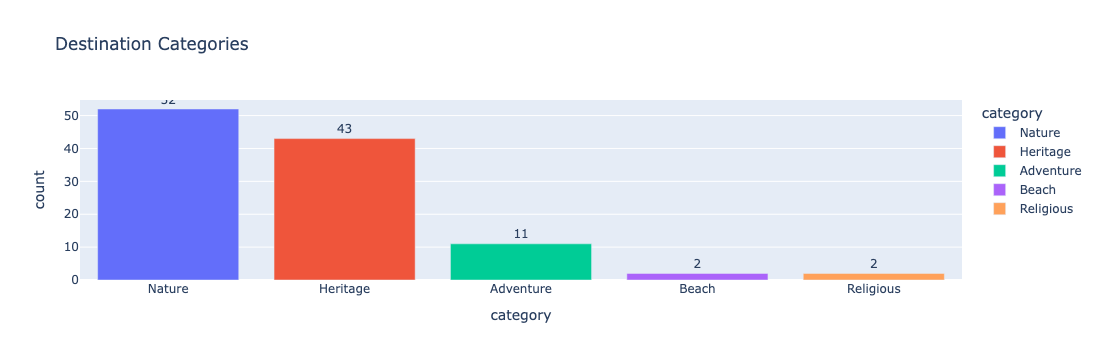

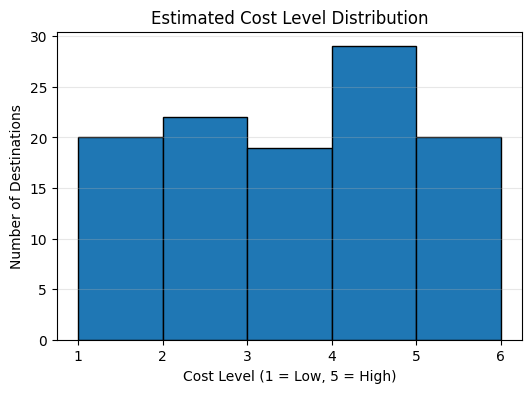

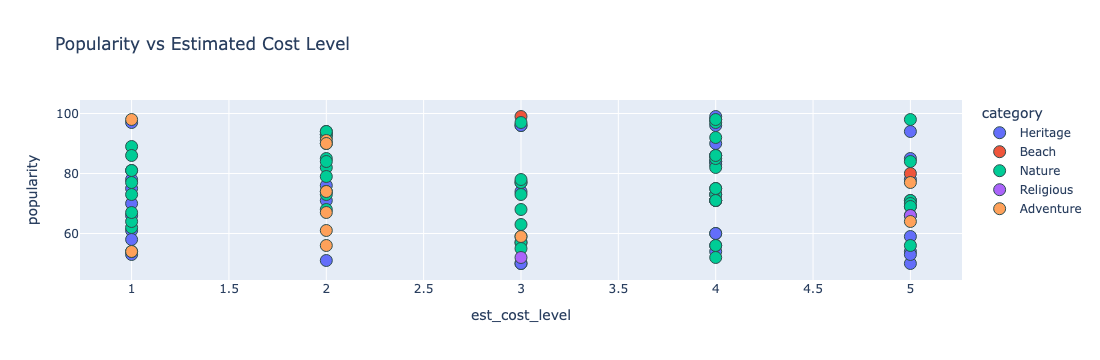

In [3]:
# Add demo numeric columns if not present (for smooth plotting)
if 'est_cost_level' not in df.columns:
    np.random.seed(42)
    df['est_cost_level'] = np.random.randint(1, 6, size=len(df))

if 'popularity' not in df.columns:
    np.random.seed(43)
    df['popularity'] = np.random.randint(50, 100, size=len(df))

if 'city' not in df.columns and 'destination_name' in df.columns:
    df['city'] = df['destination_name']

if 'category' in df.columns:
    cat_counts = df['category'].value_counts().reset_index()
    cat_counts.columns = ['category', 'count']
    fig = px.bar(
        cat_counts,
        x='category',
        y='count',
        title='Destination Categories',
        color='category',
        text='count'
    )
    fig.update_traces(textposition='outside')
    fig.show()
else:
    print("Column 'category' not found — skipping category chart.")

if 'est_cost_level' in df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(df['est_cost_level'].dropna(), bins=range(1, 7), edgecolor='k')
    plt.title('Estimated Cost Level Distribution')
    plt.xlabel('Cost Level (1 = Low, 5 = High)')
    plt.ylabel('Number of Destinations')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("Column 'est_cost_level' not found — skipping histogram.")

if all(col in df.columns for col in ['est_cost_level', 'popularity', 'city']):
    fig = px.scatter(
        df,
        x='est_cost_level',
        y='popularity',
        hover_name='city',
        color='category' if 'category' in df.columns else None,
        title='Popularity vs Estimated Cost Level'
    )
    fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()
else:
    print("Missing columns for scatter plot (need 'est_cost_level', 'popularity', 'city').")

# STEP 4: Simple ML Model — Predict Engagement Score

In [4]:
# Create engagement score (synthetic target)
demo_ml = df.copy()
demo_ml['engagement'] = (
    (demo_ml['popularity'] * 0.6)
    - (demo_ml['est_cost_level'] * 5)
    + np.random.normal(0, 5, len(demo_ml))
)
demo_ml['engagement'] = (
    (demo_ml['engagement'] - demo_ml['engagement'].min()) /
    (demo_ml['engagement'].max() - demo_ml['engagement'].min())
) * 100

# Prepare data
X = demo_ml[['est_cost_level', 'popularity']]
y = demo_ml['engagement']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
print("\nModel Performance:")
print('R2 Score:', r2_score(y_test, model.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, model.predict(X_test)))
print('RMSE:', math.sqrt(mean_squared_error(y_test, model.predict(X_test))))

models_dir = os.path.join("..", "backend", "models")
os.makedirs(models_dir, exist_ok=True)

# Save model inside backend/models 
model_path = os.path.join(models_dir, "model.pkl")
joblib.dump(model, model_path)

print(f"Model saved at: {os.path.abspath(model_path)}")

# Example prediction
sample = {'est_cost_level': 2, 'popularity': 80}
sample_df = pd.DataFrame([sample])
pred = model.predict(sample_df)[0]
print(f"\nPredicted Engagement Score: {pred:.2f}")


Model Performance:
R2 Score: 0.8602996665429482
MAE: 5.93044823543681
RMSE: 7.204339833759238
Model saved at: /Users/abhishekgiri/iCloud Drive (Archive)/Desktop/Plan My Trip– Smart Budget Travel Planner for Students/backend/models/model.pkl

Predicted Engagement Score: 66.04


# STEP 5: WEATHER DATA (Visual Crossing API)

In [5]:
def get_weather_visualcrossing(lat, lon):
    """
    Fetch current weather using Visual Crossing API.
    Example Key: HGBVXJ73SNUMKYLE57YG77JE8
    """
    api_key = "HGBVXJ73SNUMKYLE57YG77JE8"
    try:
        url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}?unitGroup=metric&key={api_key}&contentType=json"
        r = requests.get(url, timeout=8).json()
        current = r.get('currentConditions', {})
        return f"{current.get('conditions','Unknown')}, {current.get('temp','?')}°C"
    except Exception as e:
        return f"Weather fetch error: {e}"

# Demo
print("\nWeather (Demo for Dehradun 30.2684,78.0039):")
print(get_weather_visualcrossing(30.2684, 78.0039))


Weather (Demo for Dehradun 30.2684,78.0039):
Partially cloudy, 17.1°C


# STEP 6: RECOMMENDATION + ITINERARY DEMO

In [6]:
data = {
    "Destination": ["Manali", "Leh", "Shimla", "Rishikesh", "Auli", "Darjeeling"],
    "Category": ["mountain adventure", "mountain adventure", "mountain adventure", "river adventure", "mountain adventure", "hill station"],
    "Best_Time": ["October-December", "June-September", "March-June", "September-November", "December-February", "October-December"],
    "Cost_Level": [9000, 12000, 8000, 6000, 10000, 7000],
    "Latitude": [32.2396, 34.1526, 31.1048, 30.0869, 30.7530, 27.0360],
    "Longitude": [77.1887, 77.5771, 77.1734, 78.2676, 79.0193, 88.2627]
}

df2 = pd.DataFrame(data)

def recommend_destinations(df, interest, budget, month):
    return df[
        (df['Category'].str.contains(interest, case=False)) &
        (df['Cost_Level'] <= budget) &
        (df['Best_Time'].str.contains(month, case=False))
    ].sort_values('Cost_Level')

# User query
user_query = {
    "origin": "Delhi",
    "budget": 10000,
    "duration_days": 3,
    "interest": "mountain adventure",
    "month": "December"
}

# Recommendations
recommended = recommend_destinations(df2, user_query["interest"], user_query["budget"], user_query["month"])
print("\nTop Destinations:\n", recommended[['Destination','Category','Cost_Level']])

# Get weather for first match
if not recommended.empty:
    lat = recommended.iloc[0]['Latitude']
    lon = recommended.iloc[0]['Longitude']
    weather_info = get_weather_visualcrossing(lat, lon)
else:
    weather_info = "No destination found."

print("\nWeather Update:", weather_info)



Top Destinations:
   Destination            Category  Cost_Level
0      Manali  mountain adventure        9000
4        Auli  mountain adventure       10000

Weather Update: Clear, -4.1°C


# STEP 7: SAVE VISUALIZATIONS + OUTPUT SUMMARY

In [7]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) if "notebook" in os.getcwd().lower() else os.getcwd()

# Define backend/models 
models_dir = os.path.join(project_root, "backend", "models")
os.makedirs(models_dir, exist_ok=True)

fig = px.scatter(
    df2,
    x='Cost_Level',
    y='Latitude',
    color='Category',
    hover_name='Destination',
    title='Destination Overview'
)

viz_path = os.path.join(models_dir, "cost_vs_popularity.html")
fig.write_html(viz_path)
print(f"Visualization saved at: {viz_path}")

final_output = {
    "user_query": user_query,
    "recommended_destinations": recommended[['Destination', 'Category', 'Cost_Level', 'Best_Time']].to_dict(orient='records'),
    "weather": weather_info
}

json_path = os.path.join(models_dir, "final_output.json")
with open(json_path, "w") as f:
    json.dump(final_output, f, indent=4)

print(f"Final summary saved at: {json_path}")

Visualization saved at: /Users/abhishekgiri/iCloud Drive (Archive)/Desktop/Plan My Trip– Smart Budget Travel Planner for Students/backend/models/cost_vs_popularity.html
Final summary saved at: /Users/abhishekgiri/iCloud Drive (Archive)/Desktop/Plan My Trip– Smart Budget Travel Planner for Students/backend/models/final_output.json
